In [242]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [243]:
import warnings
warnings.filterwarnings("ignore")

In [244]:
df = pd.read_csv("logs.csv")

In [245]:
df.to_csv("logs.csv", index=False)

In [246]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [247]:
wr = sum(df['win']) / len(df) * 100
profit = df['profit'].sum()
print(f"ALL TIME Win Rate: {wr:.2f}%")
print(f"ALL TIME Profit: {profit:.2f}$")

ALL TIME Win Rate: 47.78%
ALL TIME Profit: 54.17$


In [248]:
df["date"] = df["timestamp"].dt.date
day_change_indices = df.groupby("date").head(1).index.tolist()[-1]
today_df = df[day_change_indices:]
today_wr = today_df['win'].sum() / len(today_df) * 100
today_profit = today_df['profit'].sum()
print(f"TODAY TIME Win Rate: {today_wr:.2f}%")
print(f"TODAY TIME Profit: {today_profit:.2f}$")

TODAY TIME Win Rate: 48.59%
TODAY TIME Profit: 22.92$


In [249]:
# Expected profit with 50% WR
expected_win = df['opponent_value'].sum() * 0.07
expected_win

np.float64(242.57170000000002)

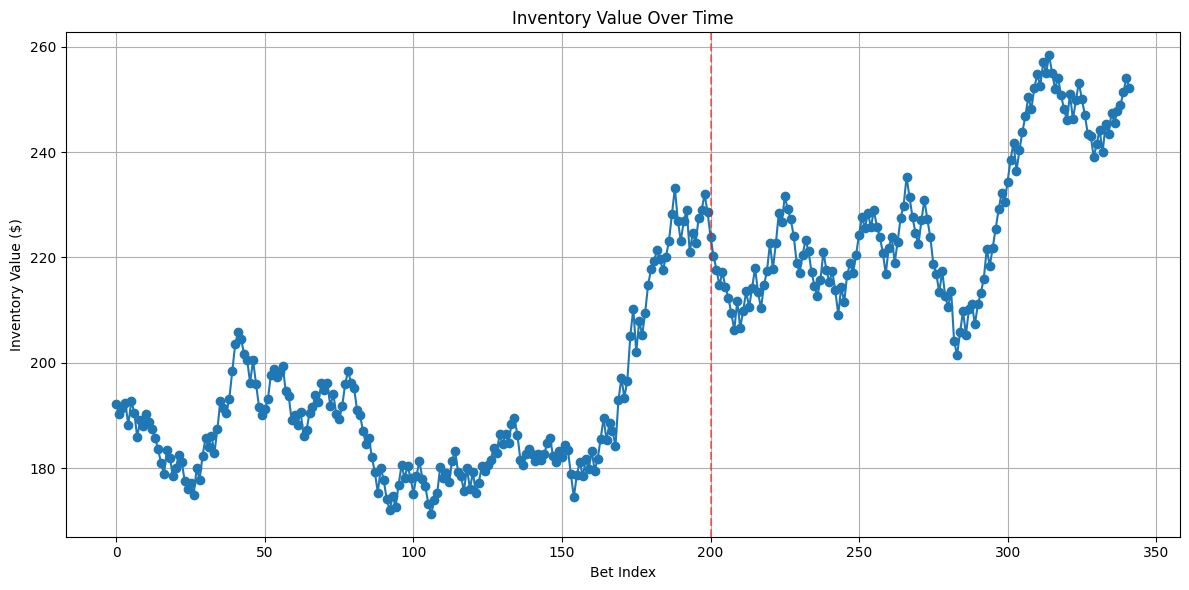

In [250]:
# Filter last N bets
last_n_bets = -len(today_df) - 200
plot_df = df[last_n_bets:].reset_index(drop=True)

# Get the start index of each unique day
plot_df["date"] = plot_df["timestamp"].dt.date
day_change_indices = plot_df.groupby("date").head(1).index.tolist()[1:]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["inventory_value"], marker='o', linestyle='-')
for idx in day_change_indices:
    plt.axvline(x=idx, color='red', linestyle='--', alpha=0.5)

plt.title("Inventory Value Over Time")
plt.xlabel("Bet Index")
plt.ylabel("Inventory Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

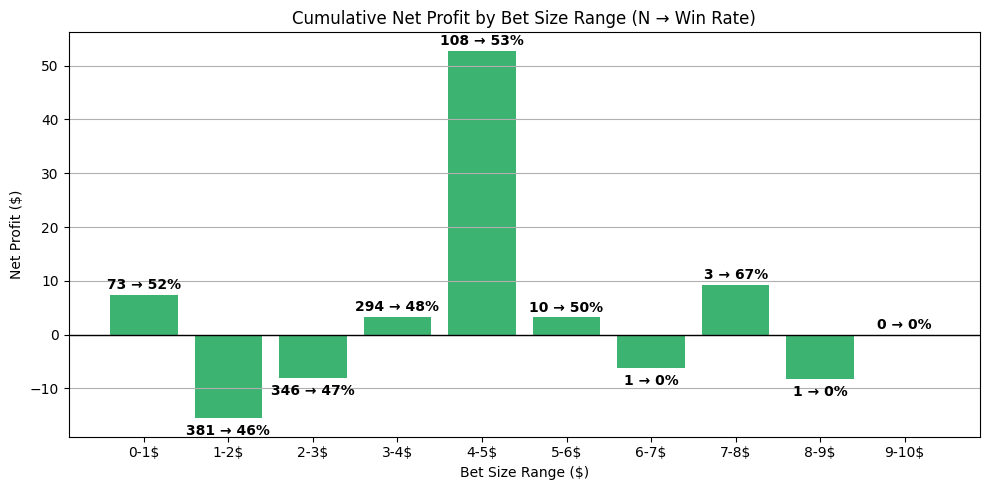

In [251]:
# Recalculate values just to be safe
bins = np.arange(0, 11, 1)
labels = [f"{i}-{i+1}$" for i in bins[:-1]]

df["bet_bin"] = pd.cut(df["your_value"], bins=bins, labels=labels, right=False)

profit_by_bin = df.groupby("bet_bin")["profit"].sum()
win_counts = df[df["win"] == 1].groupby("bet_bin")["win"].count()
total_counts = df.groupby("bet_bin")["win"].count()
win_rate_by_bin = (win_counts / total_counts).fillna(0)

# Fill missing bins to ensure clean bar alignment
profit_by_bin = profit_by_bin.reindex(labels, fill_value=0)
win_rate_by_bin = win_rate_by_bin.reindex(labels, fill_value=0)
total_counts = total_counts.reindex(labels, fill_value=0)
plt.figure(figsize=(10, 5))
bars = plt.bar(profit_by_bin.index, profit_by_bin.values, color="mediumseagreen")

# Add N -> WR% labels above bars
for bar, wr, n in zip(bars, win_rate_by_bin, total_counts):
    height = bar.get_height()
    label_text = f"{n} → {wr:.0%}"
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5 if height >= 0 else height - 1,
        label_text,
        ha='center',
        va='bottom' if height >= 0 else 'top',
        fontsize=10,
        fontweight='bold'
    )

plt.axhline(0, color='black', linewidth=1)
plt.title("Cumulative Net Profit by Bet Size Range (N → Win Rate)")
plt.xlabel("Bet Size Range ($)")
plt.ylabel("Net Profit ($)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


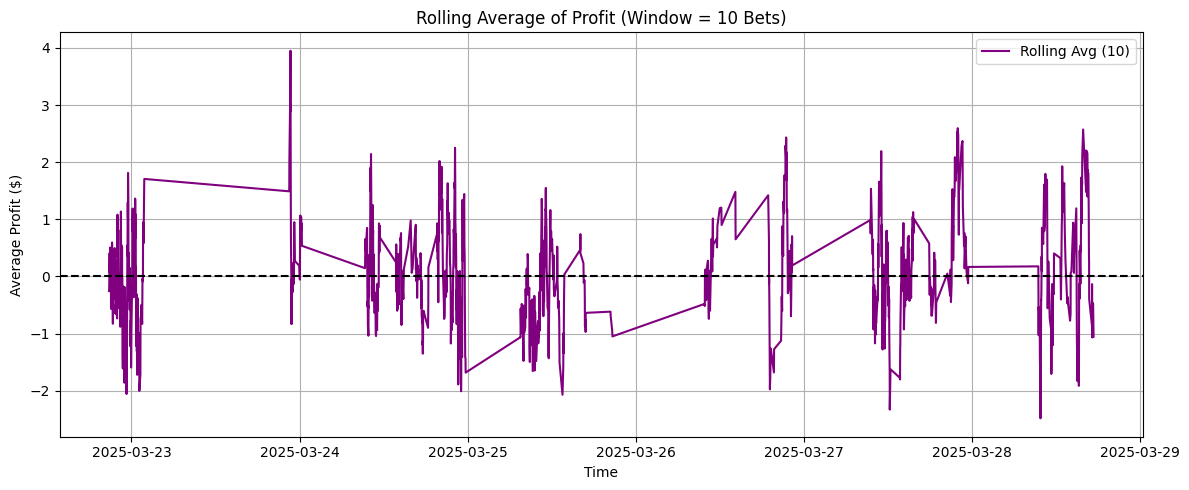

In [252]:
df["rolling_profit"] = df["profit"].rolling(window=10).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["timestamp"], df["rolling_profit"], label="Rolling Avg (10)", color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("Rolling Average of Profit (Window = 10 Bets)")
plt.xlabel("Time")
plt.ylabel("Average Profit ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()